In [3]:
!pip install rioxarray
!pip install patchify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 87.4 MB/s eta 0:00:00:00:0100:01


In [4]:

import numpy as np
import pandas as pd
import os
import rioxarray as rxr
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import patchify

2025-04-15 13:08:58.028608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744722538.223226      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744722538.278863      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# os.chdir('deforestation-detection-dataset')
img_path = '/kaggle/input/deforestation-detection-dataset/1_CLOUD_FREE_DATASET'
mask_path = '/kaggle/input/deforestation-detection-dataset/3_TRAINING_MASKS/MASK_16_GRID'

In [6]:
def read_tifs(path):

    rasters = []
    
    sub_paths = os.listdir(path)
    subfolder_path = os.path.join(path, sub_paths[0])

    files = os.listdir(subfolder_path)
    
    for f in files:
        if f.endswith('.tif'):
            tif_files = rxr.open_rasterio(os.path.join(subfolder_path, f))
            rasters.append(tif_files)

    return rasters
    
s1_rasters = read_tifs(img_path+r'/1_SENTINEL1')
s2_rasters = read_tifs(img_path+r'/2_SENTINEL2')

In [7]:
s2_rasters[0].rio.resolution() == s1_rasters[0].rio.resolution()

True

In [8]:
masks = []

for files in os.listdir(mask_path):
    if files.endswith('.tif'):
        msk = rxr.open_rasterio(os.path.join(mask_path, files))
        masks.append(msk)

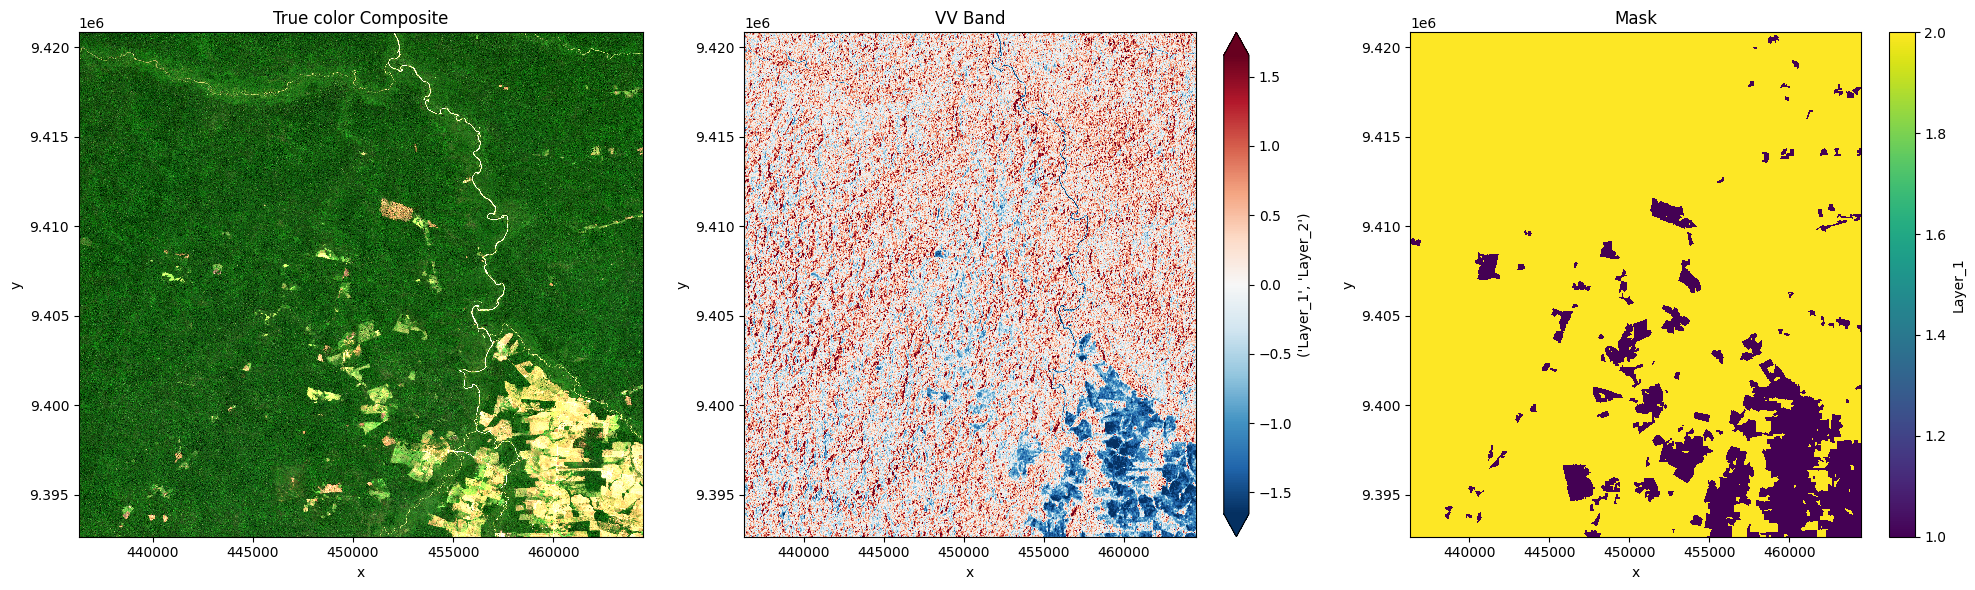

In [11]:
idx = random.randint(0, len(masks))

fig, ax = plt.subplots(1, 3, figsize = (20, 6))

axes = ax.flatten()

s2_rasters[idx].isel(band = [2, 1, 0]).plot.imshow(ax = axes[0], robust = True)
axes[0].set_title('True color Composite')
s1_rasters[idx].isel(band = 1).plot.imshow(ax = axes[1], robust = True)
axes[1].set_title('VV Band')
masks[idx].plot(ax = axes[2])
axes[2].set_title('Mask')
plt.tight_layout()

In [9]:
def patches_maker(raster_list):

    patches_ = []
    

    IMG_WIDTH = 256
    IMG_HEIGHT = 256
    BANDS = raster_list[0].shape[0]
    
    for i in raster_list:
        
        array = np.array(i)
        array_shaped = np.moveaxis(array, 0, -1)
        patches = patchify.patchify(array_shaped, (IMG_HEIGHT, IMG_WIDTH, BANDS), step=IMG_HEIGHT)
    
        for j in range(patches.shape[0]):
                    for k in range(patches.shape[1]):
                        
                        single_patch_img = patches[j,k,:,:]
                        single_patch_img = single_patch_img[-1]
                        patches_.append(single_patch_img)

    return patches_

In [10]:
s2_patches = patches_maker(s2_rasters)
s1_patches = patches_maker(s1_rasters)
mask_patches = patches_maker(masks)

In [11]:
merged_patches = []

for i in range(len(s2_patches)):
    stacked = np.dstack((s2_patches[i], s1_patches[i]))
    merged_patches.append(stacked)

In [12]:
merged_patches[0].shape

(256, 256, 6)

In [13]:
training_patches = np.array(merged_patches)
training_patches.shape

(1936, 256, 256, 6)

In [14]:
mask_patches_array = np.array(mask_patches)
mask_patches_array.shape

(1936, 256, 256, 1)

In [15]:
vals, counts = np.unique(mask_patches_array, return_counts=True)
print(vals, counts)

[0 1 2] [       3 49250491 77627202]


In [16]:
converted_patch = np.where(mask_patches_array==2, 1, 0)
vals, counts = np.unique(converted_patch, return_counts=True)
vals, counts

(array([0, 1]), array([49250494, 77627202]))

In [17]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(training_patches, converted_patch, test_size=0.2, random_state=42)

print(X_train.shape,y_train.shape)
print(X_test.shape, y_test.shape)

(1548, 256, 256, 6) (1548, 256, 256, 1)
(388, 256, 256, 6) (388, 256, 256, 1)


In [18]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, 6))

s = inputs

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPool2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPool2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), activation= 'relu', strides = (2, 2), padding = 'same')(c5)
u6 = tf.keras.layers.Concatenate()([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation= 'relu', kernel_initializer='he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), activation= 'relu', strides = (2, 2), padding = 'same')(c6)
u7 = tf.keras.layers.Concatenate()([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation= 'relu', kernel_initializer='he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), activation= 'relu', strides = (2, 2), padding = 'same')(c7)
u8 = tf.keras.layers.Concatenate()([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation= 'relu', kernel_initializer='he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), activation= 'relu', strides = (2, 2), padding = 'same')(c8)
u9 = tf.keras.layers.Concatenate()([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation= 'relu', kernel_initializer='he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(u9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding = 'same')(c9)

output = tf.keras.layers.Conv2D(1, (1, 1), activation= 'sigmoid')(c9)

I0000 00:00:1744722675.789064      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [19]:
model = tf.keras.Model(inputs = [inputs], outputs = [output])

In [20]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['accuracy'])

In [21]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Deforestation detector.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 6)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            880 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,939,217 (7.40 MB)

 Trainable params: 1,939,217 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
results = model.fit(training_patches, converted_patch, validation_split = 0.1, batch_size = 16,
                   epochs = 50, callbacks = callbacks)

Epoch 1/50


I0000 00:00:1744722732.059457     105 service.cc:148] XLA service 0x7c1fa0067270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744722732.060104     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744722733.046100     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744722747.410967     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/109 ━━━━━━━━━━━━━━━━━━━━ 53s 247ms/step - accuracy: 0.6702 - loss: 90.0086 - val_accuracy: 0.6310 - val_loss: 0.7112
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.7990 - loss: 0.5763 - val_accuracy: 0.8798 - val_loss: 0.5157
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.9108 - loss: 0.2828 - val_accuracy: 0.8965 - val_loss: 0.3136
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9262 - loss: 0.2256 - val_accuracy: 0.8487 - val_loss: 0.4297
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.9286 - loss: 0.2094 - val_accuracy: 0.8570 - val_loss: 0.3795
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.9303 - loss: 0.2062 - val_accuracy: 0.7098 - val_loss: 0.5305
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.9322 - loss: 0.1954 - val_accuracy: 0.7794 - val_loss: 0.4810
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.9286 - loss: 0.2113 - val_accuracy: 0.

In [24]:
from skimage.io import imshow

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


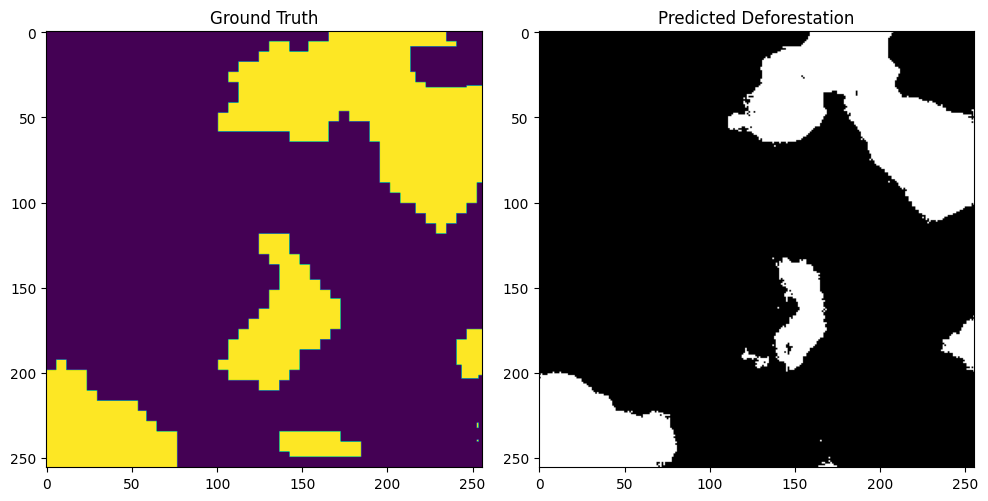

In [36]:
idx = random.randint(0, len(training_patches))

actual_patch = training_patches[idx]

reshaped = actual_patch.reshape(1, actual_patch.shape[0], actual_patch.shape[1], actual_patch.shape[2])

preds_test = model.predict(reshaped, verbose = 1)
ground_truth = converted_patch[idx]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(ground_truth)
ax[0].set_title('Ground Truth')

predicted_mask = (preds_test[0, :, :, 0] > 0.5).astype(np.uint8)
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].set_title('Predicted Deforestation')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


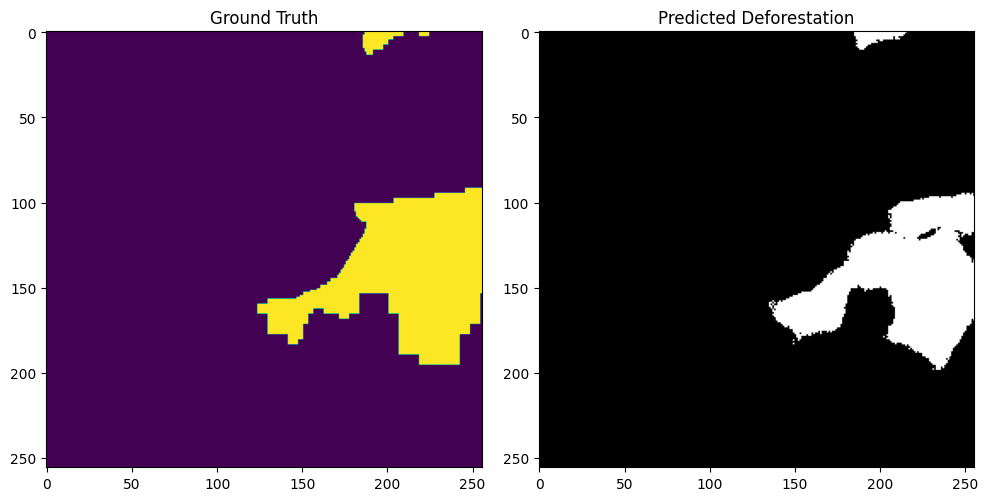

In [34]:
idx = random.randint(0, len(training_patches))

actual_patch = training_patches[idx]

reshaped = actual_patch.reshape(1, actual_patch.shape[0], actual_patch.shape[1], actual_patch.shape[2])

preds_test = model.predict(reshaped, verbose = 1)
ground_truth = converted_patch[idx]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(ground_truth)
ax[0].set_title('Ground Truth')

predicted_mask = (preds_test[0, :, :, 0] > 0.5).astype(np.uint8)
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].set_title('Predicted Deforestation')

plt.tight_layout()
plt.show()

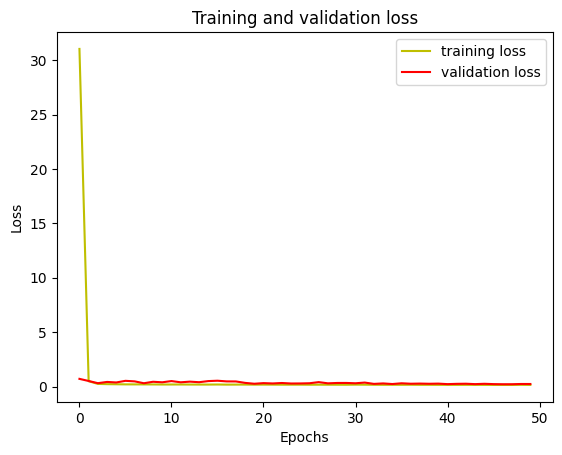

In [42]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(loss, 'y', label = 'training loss')
plt.plot(val_loss, 'r', label = 'validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

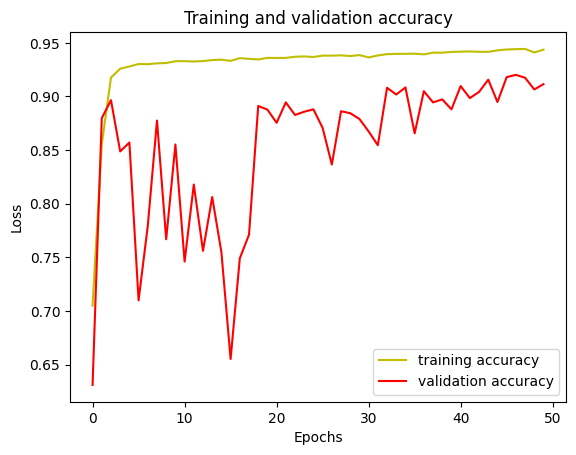

In [43]:
loss = results.history['accuracy']
val_loss = results.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(loss, 'y', label = 'training accuracy')
plt.plot(val_loss, 'r', label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

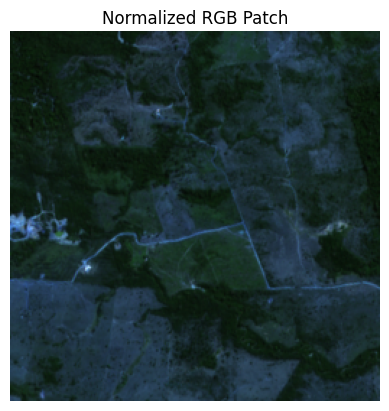

In [50]:
img = training_patches[0, :, :, :3]

# If values are float but >1
if img.max() > 1:
    img = img / img.max()

plt.imshow(img)
plt.axis('off')
plt.title("Normalized RGB Patch")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


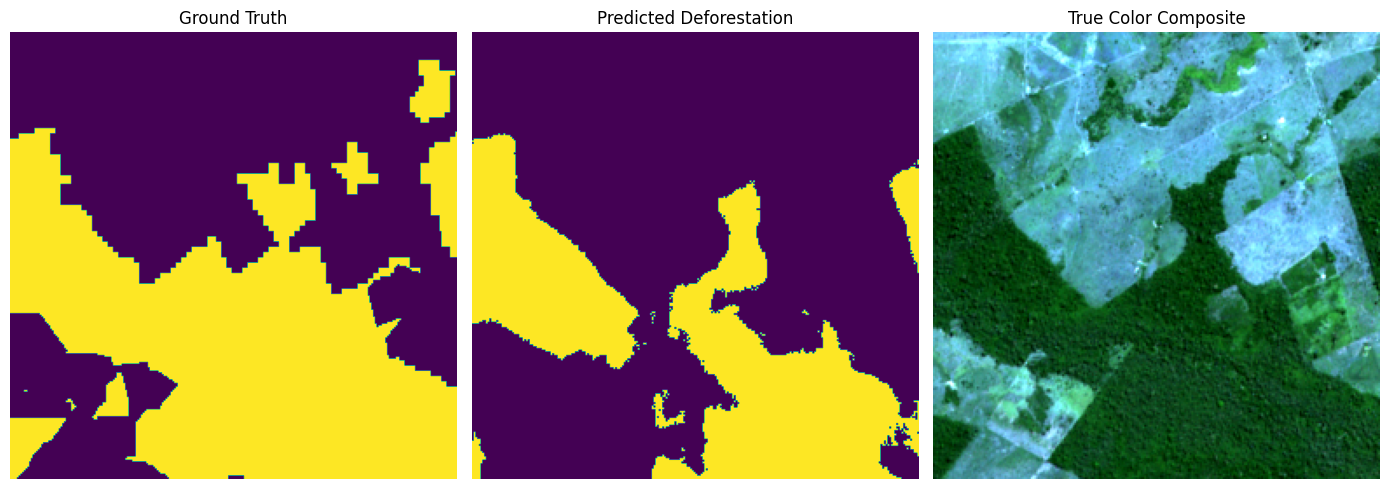

In [61]:
idx = random.randint(0, len(training_patches)-1)

img = training_patches[idx, :, :, :3]

p2 = np.percentile(img, 2)
p98 = np.percentile(img, 98)

img_stretched = np.clip(img, p2, p98)
img_stretched = (img_stretched - p2) / (p98 - p2 + 1e-8)

actual_patch = training_patches[idx]

reshaped = actual_patch.reshape(1, actual_patch.shape[0], actual_patch.shape[1], actual_patch.shape[2])

preds_test = model.predict(reshaped, verbose = 1)

predicted_mask = (preds_test[0, :, :, 0] > 0.5).astype(np.uint8)

ground_truth = converted_patch[idx]

fig, ax = plt.subplots(1, 3, figsize=(14, 5))

ax[0].imshow(ground_truth)
ax[0].set_title('Ground Truth')
ax[0].axis('off')

ax[1].imshow(predicted_mask)
ax[1].set_title('Predicted Deforestation')
ax[1].axis('off')

ax[2].imshow(img_stretched)
ax[2].set_title("True Color Composite")
ax[2].axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


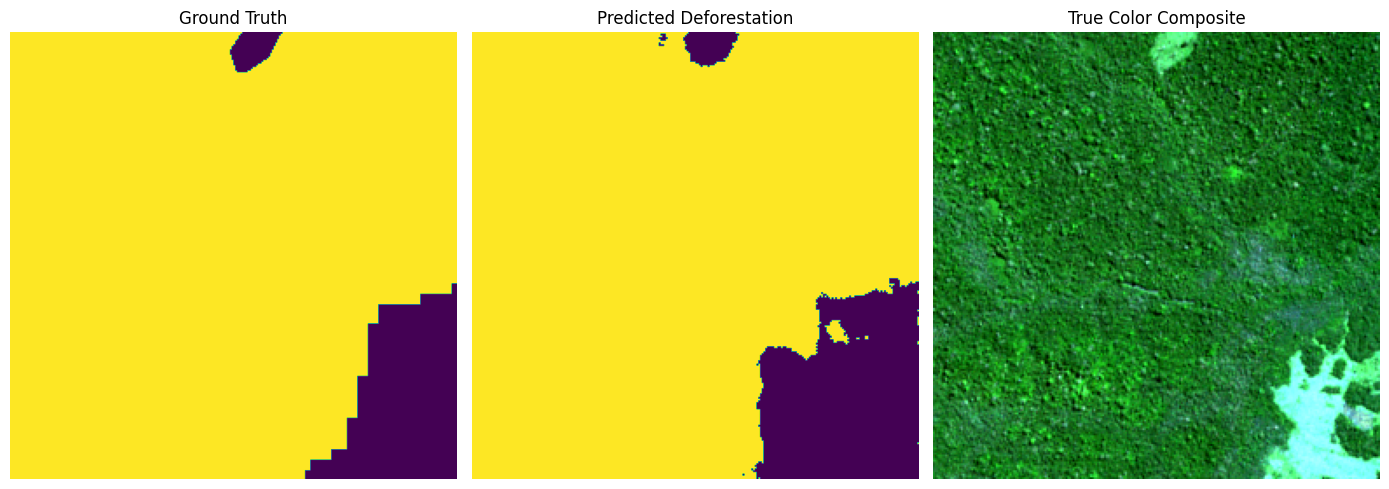

In [63]:
idx = random.randint(0, len(training_patches)-1)

img = training_patches[idx, :, :, :3]

p2 = np.percentile(img, 2)
p98 = np.percentile(img, 98)

img_stretched = np.clip(img, p2, p98)
img_stretched = (img_stretched - p2) / (p98 - p2 + 1e-8)

actual_patch = training_patches[idx]

reshaped = actual_patch.reshape(1, actual_patch.shape[0], actual_patch.shape[1], actual_patch.shape[2])

preds_test = model.predict(reshaped, verbose = 1)

predicted_mask = (preds_test[0, :, :, 0] > 0.5).astype(np.uint8)

ground_truth = converted_patch[idx]

fig, ax = plt.subplots(1, 3, figsize=(14, 5))

ax[0].imshow(ground_truth)
ax[0].set_title('Ground Truth')
ax[0].axis('off')

ax[1].imshow(predicted_mask)
ax[1].set_title('Predicted Deforestation')
ax[1].axis('off')

ax[2].imshow(img_stretched)
ax[2].set_title("True Color Composite")
ax[2].axis('off')

plt.tight_layout()
plt.show()